Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

# Implementing a neural network using nvmath-python

In this notebook we will demonstrate how you can use nvmath-python matrix multiplication capabilities to implement a simple neural network recognizing digits from MNIST dataset. We will show how matmul epilogs can be used to simplify implementation and improve performance of both forward and backward pass. To learn more about how to use nvmath-python, please refer to the previous notebooks.

We will use PyTorch to conveniently load and preprocess the data, but the model itself will be implemented in CuPy and nvmath-python.

## MNIST Dataset

[MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a set of handwritten digits in 28x28 images. As we mentioned before, we will use PyTorch for convenient data-loading. Let us define a helper function for data-loading, which will return normalized and flattened images from MNIST dataset converted into CuPy arrays.

*Normalization* means adjusting all of the images to have the same mean and standard deviation, which improves training convergence. *Flattening* means reshaping the image from its original 2D form ($28\times 28$ pixels) to a 1D vector (of size $28 \cdot 28 = 784$), which can be directly fed to the input layer of the network.

In [1]:
import cupy
import torch  # For data loading only
from torchvision import datasets, transforms  # For data loading only

BATCH_SIZE = 256


def get_loader(*, train: bool):
    """
    Returns an iterator over cupy arrays representing images from MNIST dataset.
    """
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Lambda(lambda x: torch.flatten(x)),
        ]
    )

    dataset = datasets.MNIST("./data", train=train, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
    return map(lambda x: (cupy.asarray(x[0]), cupy.asarray(x[1])), loader)

Let us plot first few images from the dataset:

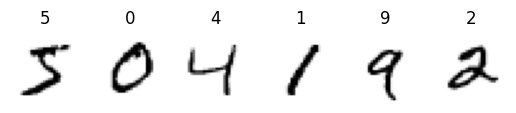

In [2]:
from matplotlib import pyplot as plt

loader = get_loader(train=True)
images, labels = next(loader)

fig, axs = plt.subplots(1, 6)
for ax, image, label in zip(axs, images, labels, strict=False):
    ax.imshow(image.get().reshape(28, 28), cmap="Grays")
    ax.axis("off")
    ax.set_title(str(label))

## Network architecture

Our network will have a single hidden layer followed by a ReLU activation. We will use sigmoid as the activation for the output layer and Binary Cross-Entropy as the loss. A simple [mini-batch SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (Stochastic Gradient Descent) will be used to optimize: we will process a batch of 256 images in each iteration and update model weights after each iteration.

While this is a very simple network, the concepts it is based on can be generalized to more complex architectures.

Let us denote the matrices of weights and biases of hidden and output layer as $W_H$, $B_H$, $W_O$, $B_O$ respectively. The forward pass of our network can be written like this in terms of matrix multiplication:

$$
\text{forward}(x) = \sigma\left(W_O \;\text{relu}\left(W_Hx^T + B_H\right) + B_O\right)
$$

The loss function, Binary Cross-Entropy, is defined as:
$$
L = -\text{mean}\left(y_i \cdot \log(\hat{y}_i)\right)
$$

### Gradients

As our activation function is the sigmoid, the gradient of the loss function with respect to sigmoid input will simplify to just $(\hat{y} - y)$.

For linear layer with weights $W$, which produced $Y = WX$ from its input $X$, the gradient is the following:
$$
\frac{\partial L}{\partial W} = X^T \frac{\partial L}{\partial Y}
$$

In our network, we use ReLU activation and need to handle it as well during the backpropagation pass. For $Y = \text{relu}(X)$, given $\frac{\partial L}{\partial Y}$, we will have to compute $\frac{\partial L}{\partial X}$, which is:
$$
\frac{\partial L}{\partial X} =
\begin{cases}
0&\text{if $X<0$} \\
\frac{\partial L}{\partial X} &\text{if $X \geq 0$} \\
\end{cases}
$$
To be able to compute this value during backward pass, we will remember a `relu_mask` indicating the sign of values in $X$ during forward pass. The `RELU_AUX` epilog allows us to compute this mask automatically. The mask returned by `RELU_AUX` is a bitmask (to save the space) and can be later use with `DRELU_*` epilogs to compute the gradient.

## Implementation baseclass

`MnistNetBase` will serve as the base class for our implementation of the model. It handles weight and bias initialization, but doesn't implement forward and backward pass. We will provide implementations for them later in the notebook.

In [3]:
class MnistNetBase:
    def __init__(self, num_inputs, num_hidden, num_outputs):
        cupy.random.seed(1234)

        stdev1 = 1.0 / (num_inputs**0.5)
        self.weights_hidden = cupy.random.uniform(-stdev1, stdev1, (num_hidden, num_inputs), dtype=cupy.float32)
        self.bias_hidden = cupy.random.uniform(-stdev1, stdev1, num_hidden, dtype=cupy.float32)

        stdev2 = 1.0 / (num_hidden**0.5)
        self.weights_output = cupy.random.uniform(-stdev2, stdev2, (num_outputs, num_hidden), dtype=cupy.float32)
        self.bias_output = cupy.random.uniform(-stdev2, stdev2, num_outputs, dtype=cupy.float32)

    def forward(self):
        raise NotImplementedError()

    def backward(self, grad):
        # return grad_weights_hidden, grad_bias_hidden, grad_weights_output, grad_bias_output
        raise NotImplementedError()

## Training framework

In this section we will implement the boilerplate that we will use to train and test the network.

First, let us define a few helper functions.

In [4]:
def one_hot(tensor, num_classes):
    """
    Returns one-hot encoding of a 1-dimensional tensor
    """
    assert len(tensor.shape) == 1
    n = tensor.shape[0]
    result = cupy.zeros((n, num_classes), dtype=cupy.float32)
    result[cupy.arange(n), tensor] = 1
    return result


def sigmoid(x):
    return 1 / (1 + cupy.exp(-x))


def binary_cross_entropy(pred, target):
    """
    Computes binary cross entropy loss between predictions and (one-hot encoded) target.
    """
    eps = 1e-8
    return -cupy.mean((1 - target) * cupy.log(1 - pred + eps) + target * cupy.log(pred + eps))

Now let us define the training loop.

In [5]:
def train(model):
    """
    Trains the model for one epoch.
    """
    train_loader = get_loader(train=True)
    for idx, (data, target) in enumerate(train_loader):
        output = model.forward(data)

        loss = binary_cross_entropy(output, one_hot(target, 10))

        if idx % 20 == 0:
            print(f"Batch {idx}  Loss: {loss}")

        # Compute gradient of binary cross-entropy and sigmoid...
        grad = (output - one_hot(target, 10)) / BATCH_SIZE

        # ...and backpropagate it through the model
        grad_weights_hidden, grad_bias_hidden, grad_weights_output, grad_bias_output = model.backward(grad)

        # Update the model parameters according to the gradients
        LR = 0.1
        model.weights_hidden -= LR * grad_weights_hidden
        model.bias_hidden -= LR * grad_bias_hidden
        model.weights_output -= LR * grad_weights_output
        model.bias_output -= LR * grad_bias_output

Finally, let us define a function to test the accuracy on test data.

In [6]:
def test(model):
    """
    Tests the model on test data and returns its accuracy
    """
    test_loader = get_loader(train=False)
    correct, total = 0, 0
    for data, target in test_loader:
        output = model.forward(data)
        pred = cupy.argmax(output, axis=1)
        correct += (pred == target).sum().item()
        total += BATCH_SIZE
    return correct / total

And a function to visualize model predictions:

In [7]:
def plot_predictions(model, num_samples=10):
    loader = get_loader(train=False)
    images, labels = next(loader)
    predictions = cupy.argmax(model.forward(images), axis=1)
    fig, axs = plt.subplots(1, num_samples)
    for ax, image, label, prediction in zip(axs, images, labels, predictions, strict=False):
        ax.imshow(image.get().reshape(28, 28), cmap="Grays")
        ax.axis("off")
        ax.set_title(f"{prediction} ({label})")

## Network implementation

In our implementation, we will use a stateful `Matmul` objects to amortize the planning cost across multiple iterations of the network. 
We will use a lazy approach, initializing each `Matmul` on its first use. Alternatively, we could initialize them in `__init__`.

Note that in some places we use extra transpositions to match the layout requirements of the cuBLAS epilogs used.

In [8]:
from nvmath.linalg.advanced import Matmul, MatmulEpilog as Epilog


class MnistNet(MnistNetBase):
    def __init__(self, inputs, hidden, outputs):
        super().__init__(inputs, hidden, outputs)
        self.forward_mm1 = self.forward_mm2 = None
        self.backward_mm_weights_hidden = self.backward_mm_weights_output = self.backward_mm_masked = None

    def forward(self, x):
        # First linear layer, fused with ReLU + bias
        if self.forward_mm1 is None:
            self.forward_mm1 = Matmul(self.weights_hidden, x.T)
            self.forward_mm1.plan(epilog=Epilog.RELU_AUX_BIAS, epilog_inputs={"bias": self.bias_hidden})
        self.forward_mm1.reset_operands(b=x.T)
        y, epilog_outputs = self.forward_mm1.execute()

        # Second linear layer, fused with bias
        if self.forward_mm2 is None:
            self.forward_mm2 = Matmul(self.weights_output, y)
            self.forward_mm2.plan(epilog=Epilog.BIAS, epilog_inputs={"bias": self.bias_output})
        self.forward_mm2.reset_operands(b=y)
        z = self.forward_mm2.execute().T

        # Save values needed for backward pass
        self.x, self.y, self.relu_mask = x, y.T, epilog_outputs["relu_aux"]

        return sigmoid(z)

    def backward(self, grad):
        # Gradient of the second linear layer
        grad_bias_output = grad.sum(axis=0)
        if self.backward_mm_weights_output is None:
            self.backward_mm_weights_output = Matmul(grad.T, self.y)
            self.backward_mm_weights_output.plan()
        self.backward_mm_weights_output.reset_operands(a=grad.T, b=self.y)
        grad_weights_output = self.backward_mm_weights_output.execute()

        # Gradient of ReLU.
        # DRELU_BGRAD epilog applies the mask provided in epilog_inputs["relu_aux"] to the result
        # and also puts bias gradient (sum of the result along the second axis) in epilog_outputs["drelu_bgrad"].
        if self.backward_mm_masked is None:
            self.backward_mm_masked = Matmul(self.weights_output.T, grad.T)
            self.backward_mm_masked.plan(epilog=Epilog.DRELU_BGRAD, epilog_inputs={"relu_aux": self.relu_mask})
        self.backward_mm_masked.reset_operands(b=grad.T, epilog_inputs={"relu_aux": self.relu_mask})
        grad_masked, epilog_outputs = self.backward_mm_masked.execute()

        # Gradient of the second linear layer
        grad_bias_hidden = epilog_outputs["drelu_bgrad"]
        if self.backward_mm_weights_hidden is None:
            self.backward_mm_weights_hidden = Matmul(grad_masked, self.x)
            self.backward_mm_weights_hidden.plan()
        self.backward_mm_weights_hidden.reset_operands(a=grad_masked, b=self.x)
        grad_weights_hidden = self.backward_mm_weights_hidden.execute()

        return grad_weights_hidden, grad_bias_hidden, grad_weights_output, grad_bias_output

    def __del__(self):
        for mm in (
            self.forward_mm1,
            self.forward_mm2,
            self.backward_mm_weights_output,
            self.backward_mm_masked,
            self.backward_mm_weights_hidden,
        ):
            if mm is not None:
                mm.free()
        super.__del__(self)

Let us see if it works:

In [9]:
model = MnistNet(784, 30, 10)
train(model)
print(f"Accuracy: {test(model)}")

Batch 0  Loss: 0.6833281517028809
Batch 20  Loss: 0.14179669320583344
Batch 40  Loss: 0.09231308847665787
Batch 60  Loss: 0.08305539935827255
Batch 80  Loss: 0.09161611646413803
Batch 100  Loss: 0.06788051128387451
Batch 120  Loss: 0.0804247111082077
Batch 140  Loss: 0.07379399240016937
Batch 160  Loss: 0.06432733684778214
Batch 180  Loss: 0.07992459833621979
Batch 200  Loss: 0.05768051743507385
Batch 220  Loss: 0.056580446660518646
Accuracy: 0.9145633012820513


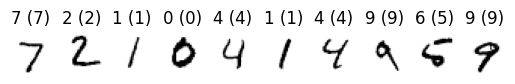

In [10]:
plot_predictions(model)